In [ ]:
!pip uninstall -y transformers datasets numpy
!pip install transformers==4.28.1 datasets==2.10.1 numpy==1.26.4 scikit-learn --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
kaggle-environments 1.17.6 requires transformers>=4.33.1, but you have transformers 4.28.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but y

# ***Mount Google Drive & Load CSV Files***

In [ ]:
import pandas as pd

train_path = "/kaggle/input/fake-news-data/Train_1.csv"
test_path  = "/kaggle/input/fake-news-data/Test1.csv"
valid_path = "/kaggle/input/fake-news-data/Valid1.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(valid_path)

In [ ]:
train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]


In [ ]:
train_df.shape

(35918, 2)

In [ ]:
train_df.head()

,text,label
0,So the Conway marriage just took a turn and ...,0
1,Jeb Bush just unofficially placed himself on t...,0
2,21st Century Wire says While the US media con...,0
3,JERUSALEM (Reuters) - Israeli Prime Minister B...,1
4,Here s a compilation of President Trump s most...,0


In [ ]:
test_df.head()

,text,label
0,The recipient of the Presidential Medal of Fre...,0
1,"Nothing shady here, huh? Unbelievable!Even by ...",0
2,Republican front runner Donald Trump loves to ...,0
3,WASHINGTON (Reuters) - The Environmental Prote...,1
4,Hillary Clinton s supporters were calling cert...,0


# ***Tokenize Using mBERT***

In [ ]:
from transformers import BertTokenizer
from datasets import Dataset


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)


In [ ]:
def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

In [ ]:
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


# ***Train mBERT Using Trainer***

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore", message="Unable to avoid copy*")
os.environ["WANDB_DISABLED"] = "true"

from transformers import BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


2025-09-18 13:05:19.386319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758200719.594518      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758200719.658125      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***Load Model & Define Metrics***

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",           # evaluate every epoch ✅
    save_strategy="epoch",                 # save every epoch ✅
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,          # works now
    metric_for_best_model="f1"
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.002700,0.000200,1.000000,1.000000,1.000000,1.000000
2,0.002000,0.000014,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000012,1.000000,1.000000,1.000000,1.000000
4,0.000600,0.000010,1.000000,1.000000,1.000000,1.000000
5,0.000500,0.000011,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=5615, training_loss=0.0012152042450550827, metrics={'train_runtime': 3350.077, 'train_samples_per_second': 53.608, 'train_steps_per_second': 1.676, 'total_flos': 1.181313467244288e+16, 'train_loss': 0.0012152042450550827, 'epoch': 5.0})

In [ ]:
save_path = "/kaggle/working/fake_news_xlmroberta_model"

# Save model + tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("✅ Model saved to:", save_path)

# ***Results***

# ***1. Predictions on Train DataSet***


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(train_ds)
x_true = predictions.label_ids
x_pred = np.argmax(predictions.predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


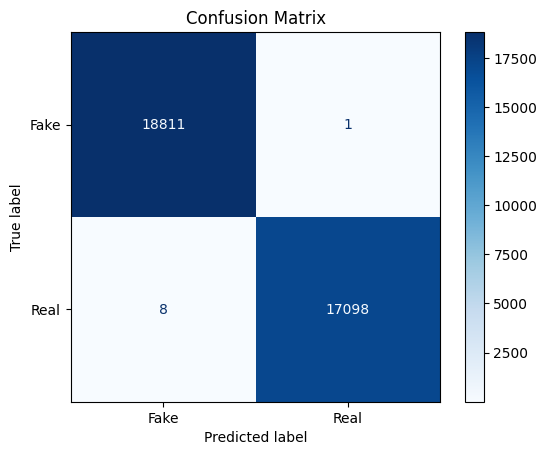

In [ ]:
cm = confusion_matrix(x_true, x_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(x_true, x_pred, target_names=["Fake", "Real"]))

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     18812
        Real       1.00      1.00      1.00     17106

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918



# **Test_Data**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

predictions = trainer.predict(test_ds)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


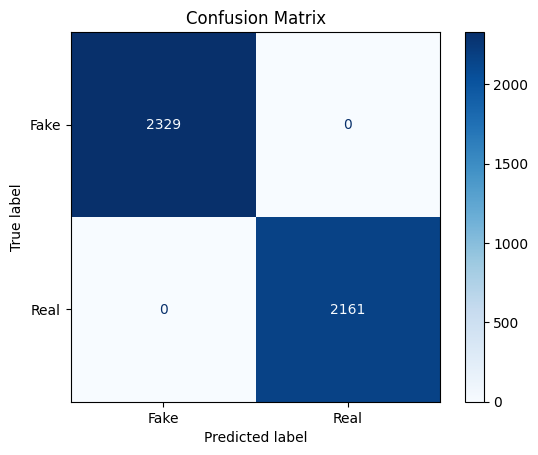

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      2329
        Real       1.00      1.00      1.00      2161

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



# ***2. ROC Curve & AUC***

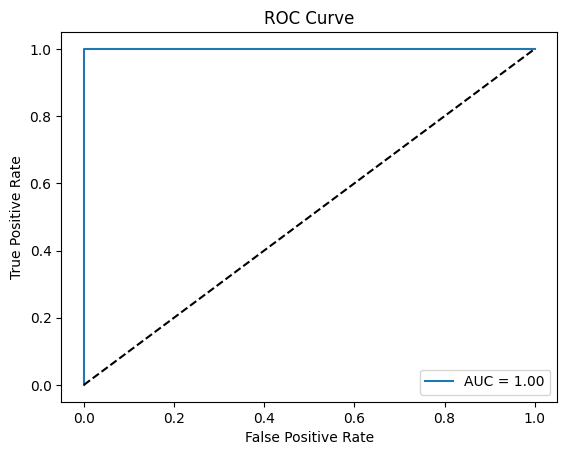

In [ ]:
from sklearn.metrics import roc_curve, auc

y_probs = predictions.predictions[:,1]  # probability for "Real" class
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], "k--")  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ***3. Precision-Recall Curve***

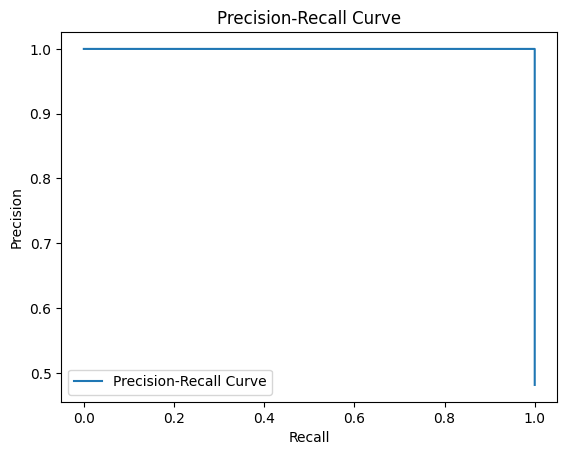

In [ ]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_true, y_probs)

plt.figure()
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ***Learning curves (training vs validation loss / accuracy)***

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# extract history (works if trainer logged eval and train losses)
history = trainer.state.log_history  # list of dicts

In [ ]:
# parse into per-epoch lists
train_losses = []
eval_losses = []
eval_acc = []
eval_prec = []
eval_rec = []
eval_f1 = []
epochs = []

for record in history:
    # records include step, loss, eval_loss, epoch, eval_accuracy, etc.
    if 'loss' in record and 'epoch' in record:
        # training loss logged at steps; keep last per epoch
        train_losses.append((record['epoch'], record['loss']))
    if 'eval_loss' in record:
        epochs.append(record.get('epoch', len(epochs)+1))
        eval_losses.append(record['eval_loss'])
        # optional metrics (if compute_metrics returns them)
        eval_acc.append(record.get('eval_accuracy', np.nan))
        eval_prec.append(record.get('eval_precision', np.nan))
        eval_rec.append(record.get('eval_recall', np.nan))
        eval_f1.append(record.get('eval_f1', np.nan))

# Convert to arrays aligned by epoch
# For training loss we take last loss value per epoch
if train_losses:
    # dict epoch->loss (keep last logged loss for each epoch)
    ep_train = {}
    for ep, loss in train_losses:
        ep_train[ep] = loss
    train_epochs = sorted(ep_train.keys())
    train_loss_vals = [ep_train[e] for e in train_epochs]
else:
    train_epochs, train_loss_vals = [], []

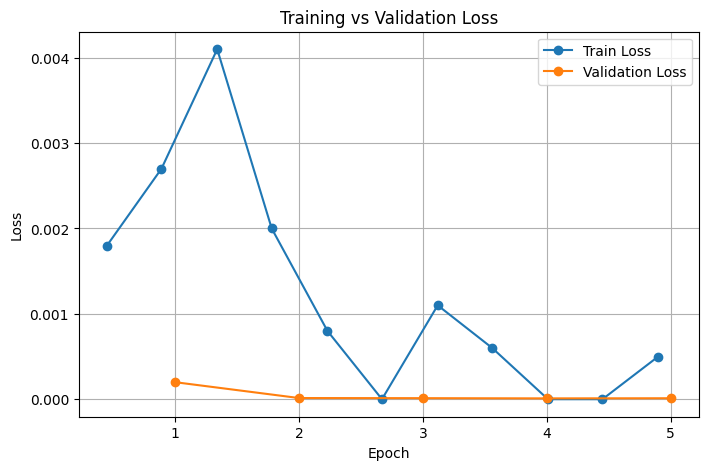

In [ ]:
# Plot losses
plt.figure(figsize=(8,5))
if train_loss_vals:
    plt.plot(train_epochs, train_loss_vals, label='Train Loss', marker='o')
if epochs:
    plt.plot(epochs, eval_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

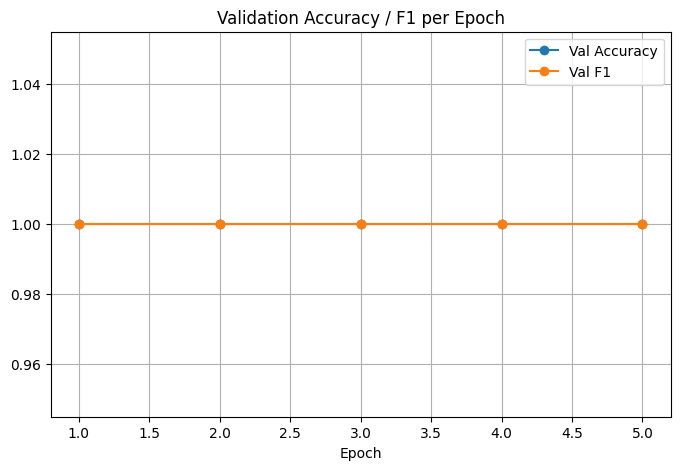

In [ ]:
# Plot accuracy/F1 if available
if any(np.isfinite(eval_acc)):
    plt.figure(figsize=(8,5))
    plt.plot(epochs, eval_acc, label='Val Accuracy', marker='o')
    if any(np.isfinite(eval_f1)):
        plt.plot(epochs, eval_f1, label='Val F1', marker='o')
    plt.xlabel('Epoch')
    plt.title('Validation Accuracy / F1 per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# ***5-Fold Cross-Validation (Hugging Face Trainer)***

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Convert dataframe into lists
texts = train_df['text'].tolist()
labels = train_df['label'].tolist()

print("Dataset size:", len(texts))


Dataset size: 35918


In [ ]:
# Use 5 folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Debug: print sizes for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df), 1):
    print(f"Fold {fold}: Train size={len(train_idx)}, Val size={len(val_idx)}")

Fold 1: Train size=28734, Val size=7184
Fold 2: Train size=28734, Val size=7184
Fold 3: Train size=28734, Val size=7184
Fold 4: Train size=28735, Val size=7183
Fold 5: Train size=28735, Val size=7183


In [ ]:
# Pick model + tokenizer
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset wrapper
class HFTextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.enc = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
fold_metrics = []  # to store results
fold_idx = 1

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }


for train_idx, val_idx in kf.split(texts):
    print(f"\n=== Fold {fold_idx}/5 ===")

    # Split dataset
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}")

    # Build datasets
    train_dataset = HFTextDataset(train_texts, train_labels, tokenizer)
    val_dataset = HFTextDataset(val_texts, val_labels, tokenizer)

    # Reload model fresh each fold
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./cv_results/fold_{fold_idx}",
        evaluation_strategy="epoch",   # fixed: should be `evaluation_strategy`
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir=f"./cv_logs/fold_{fold_idx}",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train + evaluate
    trainer.train()
    metrics = trainer.evaluate()

    print(f"Fold {fold_idx} metrics: {metrics}")

    # Save results
    fold_metrics.append({
        "fold": fold_idx,
        "accuracy": metrics.get("eval_accuracy", np.nan),
        "precision": metrics.get("eval_precision", np.nan),
        "recall": metrics.get("eval_recall", np.nan),
        "f1": metrics.get("eval_f1", np.nan)
    })

    fold_idx += 1



=== Fold 1/5 ===
Train size: 28734, Val size: 7184


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bia

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.003300,0.001952,0.999443,0.999443,0.999443,0.999443
2,0.001300,0.003037,0.999582,0.999582,0.999582,0.999582


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 1 metrics: {'eval_loss': 0.003036864334717393, 'eval_accuracy': 0.9995824053452116, 'eval_precision': 0.9995824487946282, 'eval_recall': 0.9995824053452116, 'eval_f1': 0.9995824076711481, 'eval_runtime': 40.4772, 'eval_samples_per_second': 177.483, 'eval_steps_per_second': 5.559, 'epoch': 2.0}

=== Fold 2/5 ===
Train size: 28734, Val size: 7184


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000200,0.001043,0.999861,0.999861,0.999861,0.999861
2,0.000400,0.000530,0.999861,0.999861,0.999861,0.999861


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 2 metrics: {'eval_loss': 0.0005300865159370005, 'eval_accuracy': 0.9998608017817372, 'eval_precision': 0.9998608431728221, 'eval_recall': 0.9998608017817372, 'eval_f1': 0.9998608030247917, 'eval_runtime': 39.6577, 'eval_samples_per_second': 181.15, 'eval_steps_per_second': 5.674, 'epoch': 2.0}

=== Fold 3/5 ===
Train size: 28734, Val size: 7184


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.005400,0.000858,0.999861,0.999861,0.999861,0.999861
2,0.001300,0.000941,0.999861,0.999861,0.999861,0.999861


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 3 metrics: {'eval_loss': 0.0009407295729033649, 'eval_accuracy': 0.9998608017817372, 'eval_precision': 0.9998608422581018, 'eval_recall': 0.9998608017817372, 'eval_f1': 0.9998608026112693, 'eval_runtime': 39.7143, 'eval_samples_per_second': 180.892, 'eval_steps_per_second': 5.665, 'epoch': 2.0}

=== Fold 4/5 ===
Train size: 28735, Val size: 7183


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000600,0.002710,0.999722,0.999722,0.999722,0.999722
2,0.000300,0.001882,0.999722,0.999722,0.999722,0.999722


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 4 metrics: {'eval_loss': 0.0018816154915839434, 'eval_accuracy': 0.9997215648057914, 'eval_precision': 0.999721714060787, 'eval_recall': 0.9997215648057914, 'eval_f1': 0.9997215618116764, 'eval_runtime': 39.6303, 'eval_samples_per_second': 181.25, 'eval_steps_per_second': 5.677, 'epoch': 2.0}

=== Fold 5/5 ===
Train size: 28735, Val size: 7183


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.004300,0.002161,0.999722,0.999722,0.999722,0.999722
2,0.000600,0.002433,0.999722,0.999722,0.999722,0.999722


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fold 5 metrics: {'eval_loss': 0.0024330513551831245, 'eval_accuracy': 0.9997215648057914, 'eval_precision': 0.9997215648057914, 'eval_recall': 0.9997215648057914, 'eval_f1': 0.9997215648057914, 'eval_runtime': 39.6023, 'eval_samples_per_second': 181.379, 'eval_steps_per_second': 5.681, 'epoch': 2.0}


In [ ]:
df_folds = pd.DataFrame(fold_metrics)

print("\n=== CV Results by Fold ===")
print(df_folds)

print("\n=== Final Mean ± Std ===")
print(df_folds.mean(numeric_only=True))
print(df_folds.std(numeric_only=True))



=== CV Results by Fold ===
   fold  accuracy  precision    recall        f1
0     1  0.999582   0.999582  0.999582  0.999582
1     2  0.999861   0.999861  0.999861  0.999861
2     3  0.999861   0.999861  0.999861  0.999861
3     4  0.999722   0.999722  0.999722  0.999722
4     5  0.999722   0.999722  0.999722  0.999722

=== Final Mean ± Std ===
fold         3.000000
accuracy     0.999749
precision    0.999749
recall       0.999749
f1           0.999749
dtype: float64
fold         1.581139
accuracy     0.000116
precision    0.000116
recall       0.000116
f1           0.000116
dtype: float64


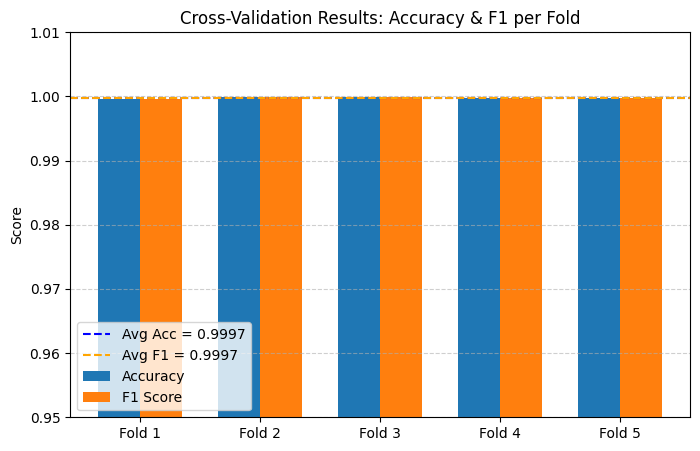

In [ ]:
import matplotlib.pyplot as plt

# Extract fold numbers and metrics
folds = df_folds['fold']
accuracy = df_folds['accuracy']
f1 = df_folds['f1']

# Plot
plt.figure(figsize=(8,5))
bar_width = 0.35
x = np.arange(len(folds))

# Bars for Accuracy & F1
plt.bar(x - bar_width/2, accuracy, width=bar_width, label="Accuracy")
plt.bar(x + bar_width/2, f1, width=bar_width, label="F1 Score")

# Add average lines
plt.axhline(y=accuracy.mean(), color="blue", linestyle="--", label=f"Avg Acc = {accuracy.mean():.4f}")
plt.axhline(y=f1.mean(), color="orange", linestyle="--", label=f"Avg F1 = {f1.mean():.4f}")

# Labels & title
plt.xticks(x, [f"Fold {i}" for i in folds])
plt.ylabel("Score")
plt.ylim(0.95, 1.01)  # zoom in for high scores
plt.title("Cross-Validation Results: Accuracy & F1 per Fold")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

# ***Class Distribution (Full Dataset)***

In [ ]:
# Count samples per class in full dataset
class_counts = train_df['label'].value_counts().sort_index()

# Create a summary table
distribution = pd.DataFrame({
    "Class": ["Fake (0)", "Real (1)"],
    "Count": [class_counts[0], class_counts[1]],
    "Percentage": [class_counts[0]/len(train_df)*100, class_counts[1]/len(train_df)*100]
})

print("\n=== Class Distribution (Full Dataset) ===")
print(distribution)

# If you also want train/val/test split distributions:
from sklearn.model_selection import train_test_split

# Using the deduplicated train_df for splitting
train_df_split, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_df_split, val_df = train_test_split(train_df_split, test_size=0.1, stratify=train_df_split['label'], random_state=42)

def get_distribution(name, subset):
    counts = subset['label'].value_counts().sort_index()
    return {
        "Split": name,
        "Fake (0)": counts[0] if 0 in counts else 0,
        "Real (1)": counts[1] if 1 in counts else 0,
        "Total": len(subset)
    }

split_distribution = pd.DataFrame([
    get_distribution("Train", train_df_split),
    get_distribution("Validation", val_df),
    get_distribution("Test", test_df)
])

print("\n=== Split-wise Distribution ===")
print(split_distribution)


=== Class Distribution (Full Dataset) ===
      Class  Count  Percentage
0  Fake (0)  18812   52.374854
1  Real (1)  17106   47.625146

=== Split-wise Distribution ===
        Split  Fake (0)  Real (1)  Total
0       Train     13544     12316  25860
1  Validation      1505      1369   2874
2        Test      3763      3421   7184


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


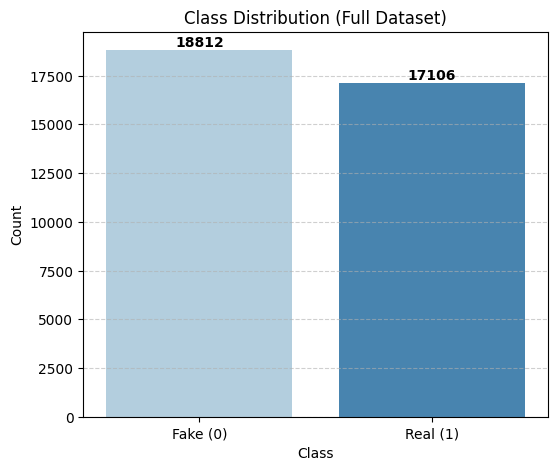

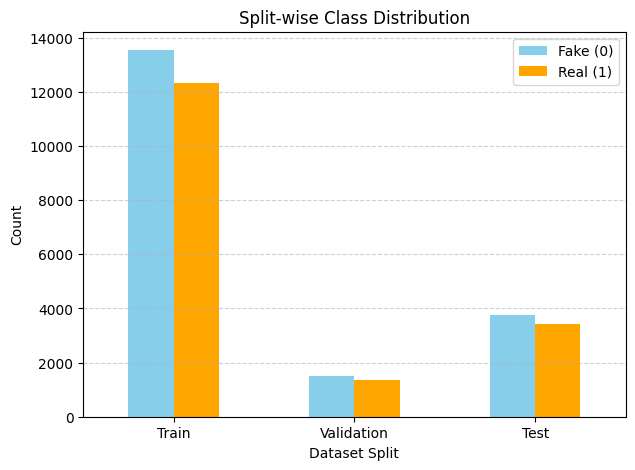

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Full dataset distribution ---
class_counts = train_df['label'].value_counts().sort_index()

plt.figure(figsize=(6,5))
sns.barplot(x=["Fake (0)", "Real (1)"], y=class_counts.values, palette="Blues")
plt.title("Class Distribution (Full Dataset)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.grid(axis="y", linestyle="--", alpha=0.6)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 200, str(v), ha='center', fontweight='bold')
plt.show()

# --- Split-wise distribution ---
splits = ["Train", "Validation", "Test"]
split_counts = [
    train_df_split['label'].value_counts().sort_index(),
    val_df['label'].value_counts().sort_index(),
    test_df['label'].value_counts().sort_index()
]

split_df = pd.DataFrame(split_counts, index=splits)
split_df.plot(kind="bar", stacked=False, figsize=(7,5), color=["skyblue","orange"])

plt.title("Split-wise Class Distribution")
plt.ylabel("Count")
plt.xlabel("Dataset Split")
plt.xticks(rotation=0)
plt.legend(["Fake (0)", "Real (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ***Prediction***

In [ ]:
import glob
import os
import numpy as np
import torch

# Path to all your SEMrush/MOZ CSVs
input_folder = "/kaggle/input/backlinks-data-cleaned"   # <-- change dataset name
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

print(f"📂 Found {len(csv_files)} CSV files")

results_summary = []

for file in csv_files:
    # === 1. Load CSV ===
    df = pd.read_csv(file)
    print(f"\nProcessing file: {os.path.basename(file)} | Rows: {len(df)}")

    # === 2. Ensure "text" column ===
    if "text" not in df.columns:
        for col in ["content","body","article","headline","title"]:
            if col in df.columns:
                df = df.rename(columns={col: "text"})
                print(f"ℹ️ Renamed column '{col}' → 'text'")
                break

    texts = df["text"].astype(str).tolist()

    # === 3. Create Dataset ===
    class NewsDataset(torch.utils.data.Dataset):
        def __init__(self, texts, tokenizer, max_length=256):
            self.enc = tokenizer(
                texts, truncation=True, padding="max_length", max_length=max_length
            )

        def __len__(self):
            return len(self.enc["input_ids"])

        def __getitem__(self, idx):
            return {k: torch.tensor(v[idx]) for k, v in self.enc.items()}

    pred_dataset = NewsDataset(texts, tokenizer)

    # === 4. Run Predictions ===
    predictions = trainer.predict(pred_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:,1].numpy()

    # === 5. Attach Predictions ===
    df["Prediction"] = y_pred
    df["Prediction"] = df["Prediction"].map({0: "Fake", 1: "Real"})
    df["Confidence"] = y_probs

    # === 6. Save File to /kaggle/working ===
    output_file = f"/kaggle/working/{os.path.basename(file).replace('.csv','_pred_2.csv')}"
    df.to_csv(output_file, index=False)
    print(f"✅ Saved predictions to {output_file}")

    # === 7. Collect Summary ===
    results_summary.append({
        "File": os.path.basename(file),
        "Total Rows": len(df),
        "Real Count": (df["Prediction"]=="Real").sum(),
        "Fake Count": (df["Prediction"]=="Fake").sum(),
        "Avg Confidence": df["Confidence"].mean()
    })

# === 8. Save Summary Report ===
summary_df = pd.DataFrame(results_summary)
summary_path = "/kaggle/working/predictions_summary.csv"
summary_df.to_csv(summary_path, index=False)

print("\n📊 Summary of all files saved to:", summary_path)
summary_df


📂 Found 5 CSV files

Processing file: sdg_news_01_cleaned.csv | Rows: 32
✅ Saved predictions to /kaggle/working/sdg_news_01_cleaned_pred_2.csv

Processing file: rt_news_cleaned.csv | Rows: 1540
✅ Saved predictions to /kaggle/working/rt_news_cleaned_pred_2.csv

Processing file: gt_news_cleaned_04.csv | Rows: 1256
✅ Saved predictions to /kaggle/working/gt_news_cleaned_04_pred_2.csv

Processing file: euro_news_clean.csv | Rows: 3271
✅ Saved predictions to /kaggle/working/euro_news_clean_pred_2.csv

Processing file: inian_news_cleaned.csv | Rows: 501
✅ Saved predictions to /kaggle/working/inian_news_cleaned_pred_2.csv

📊 Summary of all files saved to: /kaggle/working/predictions_summary.csv


,File,Total Rows,Real Count,Fake Count,Avg Confidence
0,sdg_news_01_cleaned.csv,32,12,20,0.346866
1,rt_news_cleaned.csv,1540,961,579,0.613959
2,gt_news_cleaned_04.csv,1256,892,364,0.697721
3,euro_news_clean.csv,3271,1574,1697,0.470379
4,inian_news_cleaned.csv,501,216,285,0.395977


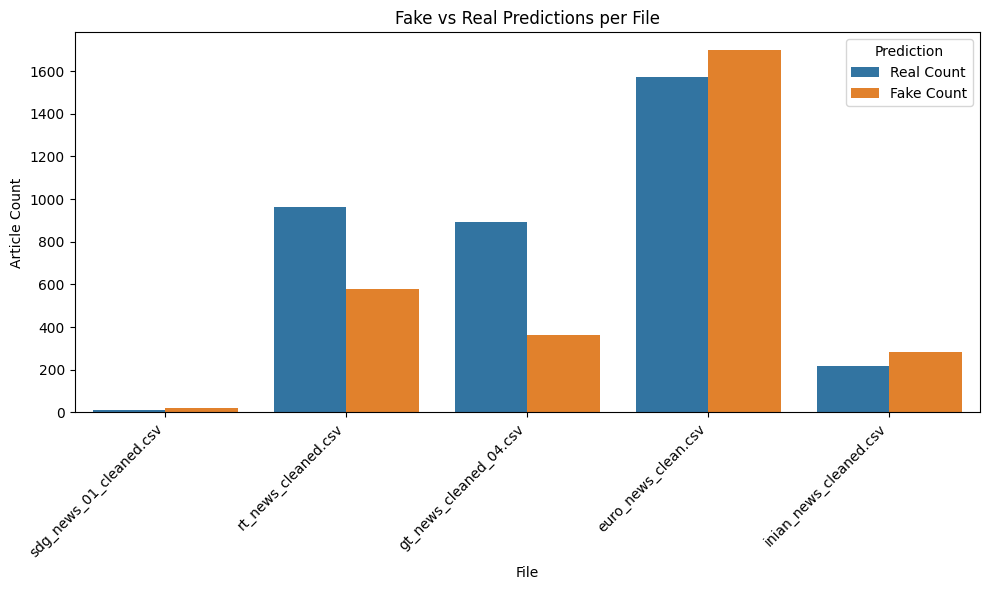

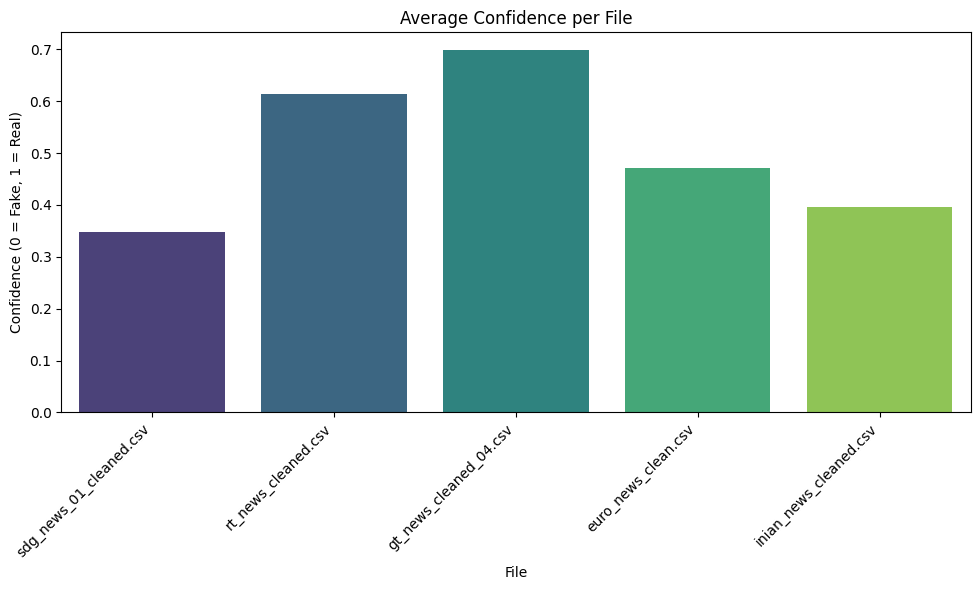

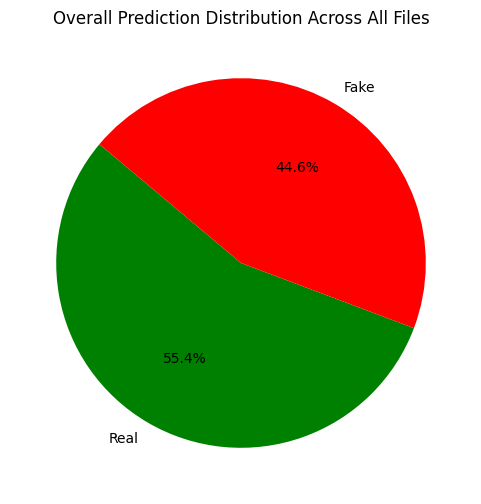

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary from previous step
summary_df = pd.read_csv("/kaggle/working/predictions_summary.csv")

# 1️⃣ Bar chart: Fake vs Real per file
plt.figure(figsize=(10,6))
sns.barplot(data=summary_df.melt(id_vars="File", value_vars=["Real Count","Fake Count"]),
            x="File", y="value", hue="variable")
plt.title("Fake vs Real Predictions per File")
plt.ylabel("Article Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Prediction")
plt.tight_layout()
plt.show()

# 2️⃣ Bar chart: Average Confidence per file
plt.figure(figsize=(10,6))
sns.barplot(data=summary_df, x="File", y="Avg Confidence", palette="viridis")
plt.title("Average Confidence per File")
plt.ylabel("Confidence (0 = Fake, 1 = Real)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3️⃣ Pie chart: Overall Fake vs Real across all files
total_fake = summary_df["Fake Count"].sum()
total_real = summary_df["Real Count"].sum()

plt.figure(figsize=(6,6))
plt.pie([total_real, total_fake],
        labels=["Real","Fake"],
        autopct="%1.1f%%",
        colors=["green","red"],
        startangle=140)
plt.title("Overall Prediction Distribution Across All Files")
plt.show()